In [1]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
case_path = '../../data/cases/'
ca_cases = pd.read_csv(case_path + 'CA_JHU_cases.csv')
fl_cases = pd.read_csv(case_path + 'FL_JHU_cases.csv')
ga_cases = pd.read_csv(case_path + 'GA_JHU_cases.csv')
ny_cases = pd.read_csv(case_path + 'NY_JHU_cases.csv')

In [3]:
cases = {'California': ca_cases, 
         'Florida': fl_cases, 
         'Georgia': ga_cases, 
         'NewYork': ny_cases}

## Preprocess

In [4]:
def preprocess(df, state):
    #Set date to datetime obj
    #df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    #start from rows where we have COVID Cases (?)
    df = df[df[state + '.JHU_ConfirmedCases.data'] > 0]
    #Given time constraints, just focus on confirmed cases
    ret_cols = ['date', state + '.JHU_ConfirmedCases.data']
    return df[ret_cols]

In [5]:
for state,df in cases.items():
    cases[state] = preprocess(df,state)
    print('{0}: {1} days available'.format(state, len(cases[state])))

California: 294 days available
Florida: 258 days available
Georgia: 263 days available
NewYork: 258 days available


In [6]:
dates = {}
for state,df in cases.items():
    temp = {}
    temp['beg'] = df.iloc[0]['date']
    temp['end'] = df.iloc[-1]['date']
    dates[state] = temp

## Split into train, 30 day test set

In [7]:
tt_cases = {}
for state,df in cases.items():
    temp = {}
    train, test = pm.model_selection.train_test_split(
        cases[state][state+'.JHU_ConfirmedCases.data'],
        test_size=30)
    temp['train'] = train
    temp['test'] = test
    tt_cases[state] = temp

## Model

### Initial models (just let auto arima do its thing)

California


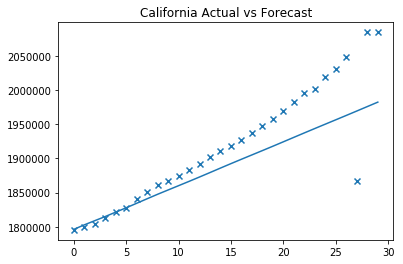

mse: 2325992934.173028
Florida


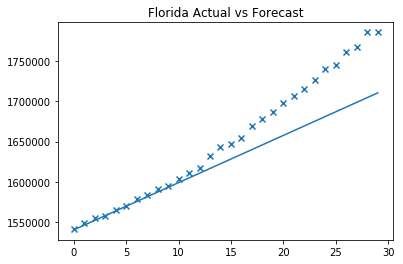

mse: 1377365509.0013373
Georgia


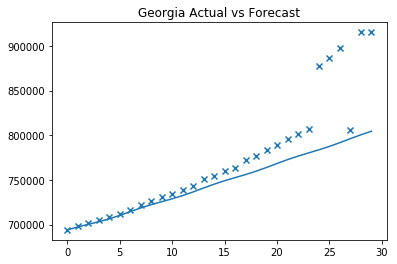

mse: 1975933603.4566603
NewYork


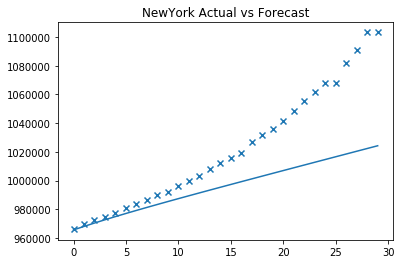

mse: 1282857239.416218


In [8]:
test_models = {}
for state,df in tt_cases.items():
    print(state)
    temp = {}
    
    model = pm.auto_arima(tt_cases[state]['train'], suppress_warnings=True, 
                       max_p = 100, max_d = 100, max_q = 50,
                       seasonal=False)
    temp['model'] = model
    pred = model.predict(n_periods=30)
    x = np.arange(30)
    plt.scatter(x, tt_cases[state]['test'], marker='x')
    plt.plot(x, pred)
    plt.title(state + ' Actual vs Forecast')
    plt.show()

    mse = mean_squared_error(tt_cases[state]['test'], pred)
    temp['mse'] = mse
    print('mse:', mse)
    
    test_models[state] = temp

In [9]:
for state, rst in test_models.items():
    print(rst)

{'model': ARIMA(order=(5, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 2325992934.173028}
{'model': ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 1377365509.0013373}
{'model': ARIMA(order=(3, 2, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 1975933603.4566603}
{'model': ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 1282857239.416218}


## Update models with test data

In [10]:
final_models = {}
for state,rst in test_models.items():
    test = tt_cases[state]['test']
    model = rst['model'].update(test)
    final_models[state] = model

In [11]:
for state,model in final_models.items():
    print(model)

 ARIMA(5,2,2)(0,0,0)[0]          
 ARIMA(0,2,1)(0,0,0)[0]          
 ARIMA(3,2,4)(0,0,0)[0]          
 ARIMA(1,2,3)(0,0,0)[0]          


Not a huge surprise that test set didn't change parameters due to small size.

## Predict for holiday season

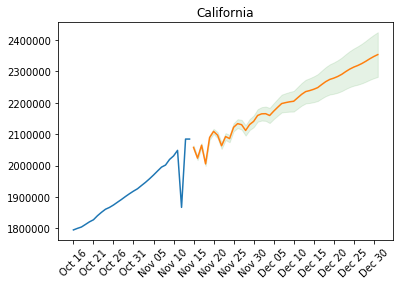

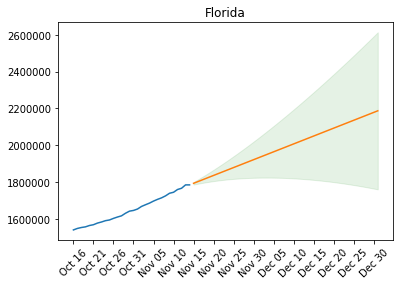

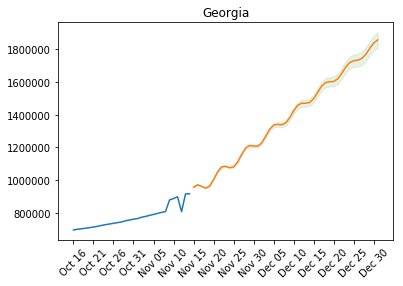

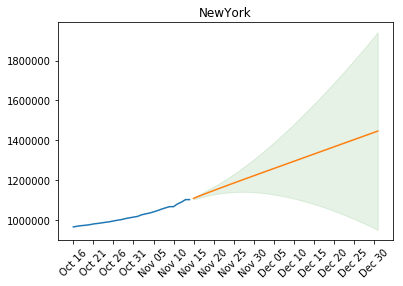

In [12]:
output = {}
#scuffed way of strformating array of npdatetimes
f = np.vectorize(lambda z: datetime.strftime(pd.to_datetime(z), '%b %d'))
for state,model in final_models.items():
    #number of days between last date of observed cases and new years
    td = (datetime.strptime('2021-01-01', '%Y-%m-%d') - 
          datetime.strptime(dates[state]['end'], '%Y-%m-%d')).days - 1
    #predict cases up until new years
    pred,ci = model.predict(n_periods=td, return_conf_int=True)
    p_ci = {}
    p_ci['preds'] = pred
    p_ci['ci'] = ci
    output[state] = p_ci
    #observed
    x = np.arange(np.datetime64(dates[state]['beg']),
                  np.datetime64(dates[state]['end']) + np.timedelta64(1, 'D'))
    x = f(x)
    #x = np.arange(len(cases[state]))
    #plot the most recent 30 days
    plt.plot(x[-30:],cases[state][state+'.JHU_ConfirmedCases.data'].to_numpy()[-30:])
    #predicted
    #pred_x = np.arange(len(x) + len(pred))
    pred_x = np.arange(np.datetime64(dates[state]['beg']),
                       np.datetime64('2021-01-01'))
    pred_x = f(pred_x)
    plt.plot(pred_x[len(x):], pred)
    plt.fill_between(pred_x[-len(pred):],
                     ci[:, 0],
                     ci[:, 1],
                     alpha=0.1, color='g')
    plt.title(state)
    test = np.concatenate((x[-30:],pred_x[len(x):]))
    plt.xticks(np.arange(len(test))[::5], test[::5], rotation=45)
    plt.show()